In [1]:
!pip install pyclustering

     |████████████████████████████████| 2.5MB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/81/ce/d19f3cba39e82fe3933680257b8df17160a57b596b4c680209
Successfully built pyclustering


In [0]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import random

from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score
from scipy.spatial.distance import pdist, squareform

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import read_sample, calculate_distance_matrix

import matplotlib.pyplot as plt

%matplotlib inline
%run GridSearchCV.ipynb

In [0]:
data_trans = pd.read_pickle('trans_data.pkl')
fd_columns = [x for x in data_trans.columns if x.find('_fd')!=-1]

In [4]:
data_trans.index.levels[1]

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE',
       ...
       'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', name='Symbols', length=503)

In [5]:
#data_trans_trunc = data_trans.loc[(data_trans.index.levels[0][data_trans.index.levels[0] > '2017-04-01'],)]
n_symbols = 200
random.seed(a=123)
data_trans_trunc = data_trans.loc[pd.IndexSlice[data_trans.index.levels[0][data_trans.index.levels[0] > '2017-01-01'],random.sample(list(data_trans.index.levels[1]), n_symbols)],:]

data_trans_trunc.shape


(113400, 18)

In [0]:
data_trans_trunc.tail()
data_trans.loc[pd.IndexSlice[:, 'AAPL'], ['Adj Close', 'F_return10']]

In [0]:
data_pivot = pd.pivot_table(data_trans_trunc, index=["Date"], columns="Symbols", values=fd_columns + ['F_return10'])

In [8]:
data_pivot.columns.levels[1]

Index(['A', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ACN', 'ADI', 'ADP', 'ADSK', 'AEP',
       ...
       'WELL', 'WFC', 'WRK', 'WU', 'WY', 'XEL', 'XRAY', 'YUM', 'ZBH', 'ZTS'],
      dtype='object', name='Symbols', length=200)

In [0]:
Y = data_pivot.loc[:,(['F_return10'],)]>0
X = data_pivot.loc[:,(fd_columns,)]

Y_train = Y.loc[Y.index < '2019-01-01', :]
X_train = X.loc[X.index < '2019-01-01', :]

Y_test = Y.loc[Y.index >= '2019-01-01', :]
X_test = X.loc[X.index >= '2019-01-01', :]


In [0]:
class MRF(RandomForestClassifier):
  
    def __init__(self, n_estimators='warn', 
                 criterion='gini', 
                 max_depth=None, 
                 min_samples_split=2, 
                 min_samples_leaf=1, 
                 min_weight_fraction_leaf=0.0, 
                 max_features='auto', 
                 max_leaf_nodes=None, 
                 min_impurity_decrease=0.0, 
                 min_impurity_split=None, 
                 bootstrap=True, 
                 oob_score=False, 
                 n_jobs=None, 
                 random_state=None, 
                 verbose=0, 
                 warm_start=False, 
                 class_weight=None):
        super().__init__(n_estimators, 
                 criterion, 
                 max_depth, 
                 min_samples_split, 
                 min_samples_leaf, 
                 min_weight_fraction_leaf, 
                 max_features, 
                 max_leaf_nodes, 
                 min_impurity_decrease, 
                 min_impurity_split, 
                 bootstrap, 
                 oob_score, 
                 n_jobs, 
                 random_state, 
                 verbose, 
                 warm_start, 
                 class_weight)
  
    def predict_proba(self, X, y=None):
        list_convert = lambda x: [1 - i[0] for i in x]
        p_prob = super().predict_proba(X)
        if not isinstance(p_prob[0][0], float):
            return np.transpose([list_convert(y) for y in p_prob])
        else: 
            return p_prob[:,1]
        
    def fit(self, X, y=None):
        #print("Fitting list of %i symbols" % y.shape[1])
        if(y.shape[1] == 1):
            super().fit(X, y.ravel())
        else:
            super().fit(X, y)


In [0]:
stock_symb = Y.columns.levels[1]

In [0]:
# X_aapl = X.loc[:, pd.IndexSlice[:, ['AAPL', 'A']]]
# Y_aapl = Y.loc[:, pd.IndexSlice[:, ['AAPL', 'A']]]

# Y_aapl.tail()
# pipeline_aapl = Pipeline([('imputer', SimpleImputer()), ('mrf', MRF(class_weight='balanced_subsample', criterion='entropy', n_estimators=100, n_jobs=-1))])

# # _wf_cv = WalkForwardCV(points_step=90, embargo=5)
# # _wf_cv.wf_cv(pipeline_aapl, X_aapl, Y_aapl)

# _gs = GridSearch(points_step=90, embargo=5)
# parameters_rf = {'mrf__max_features': (None, 'log2', 'sqrt', 2),
#                      'mrf__min_samples_leaf': (1, 0.01, 0.1)
#                     }

# _gs.run_search(X_aapl, Y_aapl, model=pipeline_aapl, parameters=parameters_rf, verbose=True)



In [0]:
class ClusteredMRF:
    
    def __init__(self, n_clusters):
        self._n_clusters = n_clusters
        
    def _build_clusters(self, Y):
        #Define stock time series distance on mutual information distance metrics
        stock_symb = Y.columns.levels[1]
        dm = pdist(np.transpose(Y), lambda x, y: 1 - normalized_mutual_info_score(x, y))
        sdm = squareform(dm)

        #Define stock clusters
        cluster_symbols = kmedoids(sdm, list(range(self._n_clusters)), data_type='distance_matrix', tolerance = 1e-10)
        cluster_symbols.process()
        clusters_ind = cluster_symbols.get_clusters()

        stock_clusters = [stock_symb[i] for i in clusters_ind]

        self._stock_clusters = stock_clusters
        self._sdm = sdm
    
    def fit(self, X, Y):
        self._build_clusters(Y)
        
        fd_columns = [x for x in X.columns.levels[0] if x.find('_fd')!=-1]
        
        #List of column index correspinding to each cluster
        _l1 = lambda i: [Y.columns.get_loc(('F_return10', c)) for c in self._stock_clusters[i]]
        _l2 = lambda i: [X.columns.get_loc((v, c)) for c in self._stock_clusters[i] for v in fd_columns]

        y_col_ind = [_l1(i) for i in range(self._n_clusters)]
        x_col_ind = [_l2(i) for i in range(self._n_clusters)]

        #List of model pipelines, one for each cluster
        pipeline_list = [Pipeline([('imputer', SimpleImputer()), ('mrf', MRF(class_weight='balanced_subsample', criterion='entropy', n_estimators=100, n_jobs=-1))]) 
                         for i in range(self._n_clusters)]

        #CV grid search of parameters separately for each cluster
        parameters_rf = {'mrf__max_features': (None, 'log2', 'sqrt', 2),
                         'mrf__min_samples_leaf': (1, 0.01, 0.1)
                        }

        self._gscv_list = [GridSearch(points_step=90, embargo=5) for i in range(self._n_clusters)]

        for i in range(self._n_clusters):
            print("Cluster %i/%i..." % (i+1, self._n_clusters))
            self._gscv_list[i].run_search(X.iloc[:, x_col_ind[i]], Y.iloc[:, y_col_ind[i]], model=pipeline_list[i], parameters=parameters_rf, verbose=True)
            print(self._gscv_list[i].best_score)
            print(self._gscv_list[i].best_params)

        self._cluster_scores = [gscv.best_score for gscv in self._gscv_list]
        self._n_symbols_clusters = [len(cl) for cl in self._stock_clusters]

        
        

In [13]:
n_clusters = np.unique([int(i) for i in np.geomspace(15, 0.3 * n_symbols, num=3)])
print(n_clusters)

cmrf_list = [ClusteredMRF(i) for i in n_clusters]

for cmrf in cmrf_list:
    cmrf.fit(X_train, Y_train)
    
 

[15 30 60]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Cluster 1/15...
{'mrf__max_features': None, 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.859799 	 CV score train: 0.085273
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.906780 	 CV score train: 0.209333
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 1.124185 	 CV score train: 0.926078
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.832755 	 CV score train: 0.083852
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.919779 	 CV score train: 0.235699
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Cluster 1/30...
{'mrf__max_features': None, 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.889238 	 CV score train: 0.088704
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.965404 	 CV score train: 0.216355
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 1.161304 	 CV score train: 1.000951
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.812314 	 CV score train: 0.087984
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.889429 	 CV score train: 0.240867
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Cluster 1/60...
{'mrf__max_features': None, 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.879382 	 CV score train: 0.089821
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.926890 	 CV score train: 0.163345
{'mrf__max_features': None, 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.970315 	 CV score train: 0.592757
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 1}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.885866 	 CV score train: 0.088994
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.01}
	CV Iteration 1/4
	CV Iteration 2/4
	CV Iteration 3/4
	CV Iteration 4/4
CV score test: 0.866013 	 CV score train: 0.186674
{'mrf__max_features': 'log2', 'mrf__min_samples_leaf': 0.1}
	CV Iteration 1/4

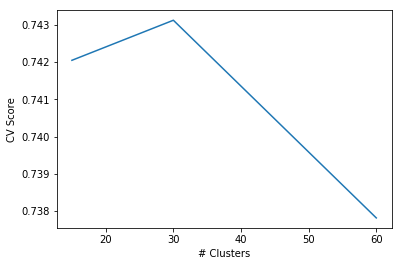

In [14]:
score_nclust = [np.sum(np.multiply(cmrf._n_symbols_clusters, cmrf._cluster_scores))/np.sum(cmrf._n_symbols_clusters) for cmrf in cmrf_list]

plt.plot(n_clusters, score_nclust)
plt.ylabel('CV Score')
plt.xlabel('# Clusters')
plt.show()

In [15]:
#Best score for any cluster
min_symb = 10

min_score = 1e10
for cmrf in cmrf_list:
    for i in range(len(cmrf._stock_clusters)):
        if len(cmrf._stock_clusters[i]) >= min_symb and cmrf._gscv_list[i].best_score < min_score:
            min_score = cmrf._gscv_list[i].best_score
            best_cluster = cmrf._stock_clusters[i]
            best_params = cmrf._gscv_list[i].best_params
          
        
print(min_score)
print(best_cluster)
print(best_params)

0.6950596145970029
Index(['L', 'CB', 'FLR', 'FTV', 'GE', 'HIG', 'LNC', 'MS', 'NLSN', 'TRV',
       'USB'],
      dtype='object', name='Symbols')
{'mrf__max_features': 2, 'mrf__min_samples_leaf': 0.01}
